In [1]:
import numpy as np 
import pandas as pd 

import lightgbm as lgb
import xgboost as xgb  # XGBoost库

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, roc_curve
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import sys
import datetime
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# 新增可视化相关库
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.2)

import features_selection as fs


# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)  # 解决seaborn中文显示问题

In [12]:
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

In [13]:
train_x,train_y,test_x,features = fs.process_features(train, test, label)

In [4]:
# 设置随机种子，保证结果可复现
np.random.seed(42)

# 假设train_x（DataFrame或数组）和train_y（Series或数组）是已有的训练数据
# 请确保在实际使用时已经正确加载了这两个变量

# 确保train_y是一维数组
if isinstance(train_y, pd.Series):
    train_y = train_y.values

# 获取特征数量和特征名称
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]

## 1. 定义基模型参数配置（2个LightGBM + 2个XGBoost）

In [5]:
def get_base_model_params():
    """返回基模型参数配置（2个LightGBM + 2个XGBoost）"""
    # LightGBM参数
    lgb_params1 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'seed': 42,
        'n_jobs': -1
    }
    
    lgb_params2 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.03,
        'num_leaves': 63,
        'max_depth': 8,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 3,
        'verbose': 0,
        'seed': 43,
        'n_jobs': -1
    }
    
    # XGBoost==0.90版本参数（兼容旧版本API）
    xgb_params1 = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': 1,
        'seed': 44,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    xgb_params2 = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 7,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.1,
        'seed': 45,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # 返回模型配置列表，包含模型类型和参数
    return [
        {'type': 'lgb', 'params': lgb_params1},
        {'type': 'lgb', 'params': lgb_params2},
        {'type': 'xgb', 'params': xgb_params1},
        {'type': 'xgb', 'params': xgb_params2}
    ]



## 2. 实现stacking（2个LGB + 2个XGB基模型）

In [6]:
def stacking_model(X, y):
    # 获取基模型参数配置
    model_params = get_base_model_params()
    print(f"将使用{len(model_params)}个基模型（2个LightGBM + 2个XGBoost）")
    
    # 初始化模型列表
    models = []
    # 创建K折交叉验证
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 训练基模型
    print("开始训练基模型...")
    for i, config in enumerate(model_params, 1):
        model_type = config['type']
        params = config['params']
        
        # 对每个参数配置，使用K折交叉验证训练
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            # 处理数据索引
            if isinstance(X, pd.DataFrame):
                X_train = X.iloc[train_idx]
                X_val = X.iloc[val_idx]
            else:
                X_train = X[train_idx]
                X_val = X[val_idx]
            
            y_train, y_val = y[train_idx], y[val_idx]
            
            # 训练不同类型的模型
            if model_type == 'lgb':
                # LightGBM训练
                lgb_train = lgb.Dataset(X_train, y_train)
                lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
                model = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    early_stopping_rounds=50,
                    verbose_eval=0
                )
                y_pred = model.predict(X_val, num_iteration=model.best_iteration)
            
            elif model_type == 'xgb':
                # XGBoost训练（兼容0.90版本）
                xgb_train = xgb.DMatrix(X_train, label=y_train)
                xgb_val = xgb.DMatrix(X_val, label=y_val)
                model = xgb.train(
                    params,
                    xgb_train,
                    num_boost_round=1000,
                    evals=[(xgb_train, 'train'), (xgb_val, 'valid')],
                    early_stopping_rounds=50,
                    verbose_eval=0
                )
                y_pred = model.predict(xgb_val, ntree_limit=model.best_iteration)
            
            # 只保留最后一折的模型作为该配置的代表
            if fold == kf.n_splits - 1:
                models.append({
                    'model': model,
                    'type': model_type
                })
                
                # 评估该模型
                auc = roc_auc_score(y_val, y_pred)
                print(f"基模型 {i}（{model_type}）验证集AUC: {auc:.4f}")
                break
    
    # 生成元特征（第二层的输入）
    print("\n生成元特征...")
    meta_features = np.zeros((X.shape[0], len(models)))
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            # XGBoost需要转换为DMatrix
            dmatrix = xgb.DMatrix(X)
            meta_features[:, i] = model.predict(dmatrix, ntree_limit=model.best_iteration)
    
    # 第二层模型训练（使用元特征，这里仍使用LightGBM）
    print("\n开始训练元模型...")
    meta_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 15,  # 元特征较少，使用较简单的模型
        'max_depth': 3,
        'verbose': 0,
        'seed': 42,
        'n_jobs': -1
    }
    
    lgb_meta_train = lgb.Dataset(meta_features, y)
    meta_model = lgb.train(
        meta_params,
        lgb_meta_train,
        num_boost_round=1000,
        valid_sets=[lgb_meta_train],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    return models, meta_model, model_params

## 3. 训练stacking模型

In [7]:
models, meta_model, model_params = stacking_model(train_x, train_y)

将使用4个基模型（2个LightGBM + 2个XGBoost）
开始训练基模型...
基模型 1（lgb）验证集AUC: 0.7323
基模型 2（lgb）验证集AUC: 0.7345
基模型 3（xgb）验证集AUC: 0.7339
基模型 4（xgb）验证集AUC: 0.7301

生成元特征...

开始训练元模型...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.844065
[200]	training's auc: 0.847437
[300]	training's auc: 0.849499
[400]	training's auc: 0.850986
[500]	training's auc: 0.852426
[600]	training's auc: 0.853737
[700]	training's auc: 0.855031
[800]	training's auc: 0.856227
[900]	training's auc: 0.857335
[1000]	training's auc: 0.858566
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.858566


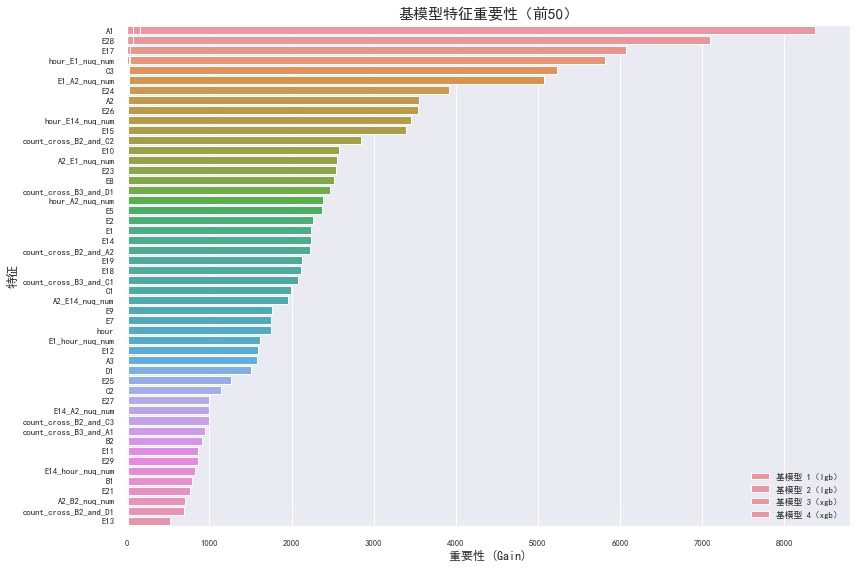

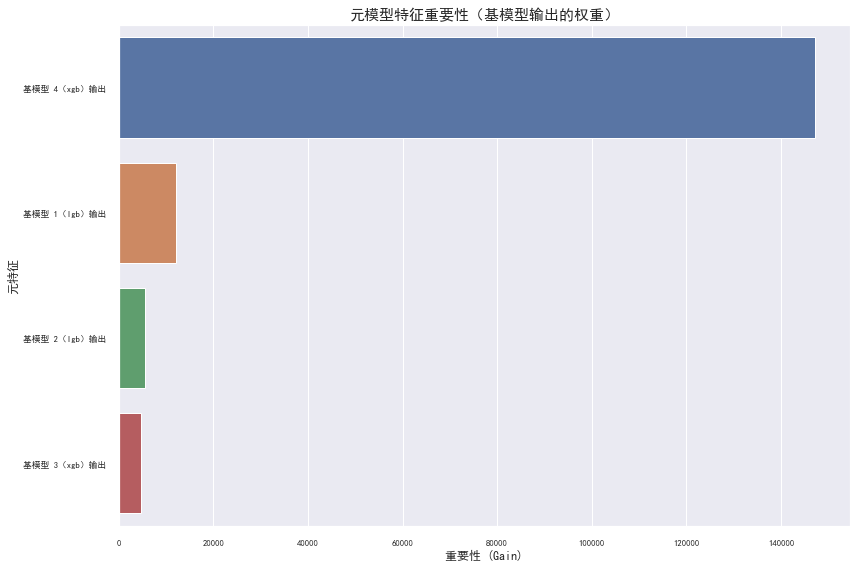

In [8]:
# 定义特征重要性可视化函数（适配混合模型）
def plot_feature_importance(models, feature_names, top_n=50, figsize=(12, 8)):
    """可视化基模型和元模型的特征重要性"""
    # 基模型特征重要性
    plt.figure(figsize=figsize)
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        # 不同模型获取特征重要性的方式不同
        if model_type == 'lgb':
            importance = model.feature_importance(importance_type='gain')
        elif model_type == 'xgb':
            importance = model.get_score(importance_type='gain').values()
            # 确保重要性数组长度与特征数量一致
            if len(importance) < len(feature_names):
                importance = list(importance) + [0]*(len(feature_names)-len(importance))
        
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance,
            'model': f'基模型 {i+1}（{model_type}）'
        })
        # 取前N个重要特征
        top_feat = feat_imp.sort_values('importance', ascending=False).head(top_n)
        sns.barplot(x='importance', y='feature', data=top_feat, label=f'基模型 {i+1}（{model_type}）')
    
    plt.title(f'基模型特征重要性（前{top_n}）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 元模型特征重要性（元特征对应基模型的预测结果）
    plt.figure(figsize=figsize)
    meta_importance = meta_model.feature_importance(importance_type='gain')
    meta_feat_imp = pd.DataFrame({
        'feature': [f'基模型 {i+1}（{models[i]["type"]}）输出' for i in range(len(models))],
        'importance': meta_importance
    })
    meta_feat_imp = meta_feat_imp.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=meta_feat_imp)
    plt.title('元模型特征重要性（基模型输出的权重）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('元特征', fontsize=12)
    plt.tight_layout()
    plt.show()

# 绘制特征重要性
plot_feature_importance(models, features)

## 多指标评估及可视化


交叉验证评估结果与可视化...
最终Stacking模型的平均AUC: 0.8578 ± 0.0590
最终Stacking模型的平均KS: 0.5508 ± 0.0984
最终Stacking模型的平均最佳F1: 0.5648 ± 0.0798


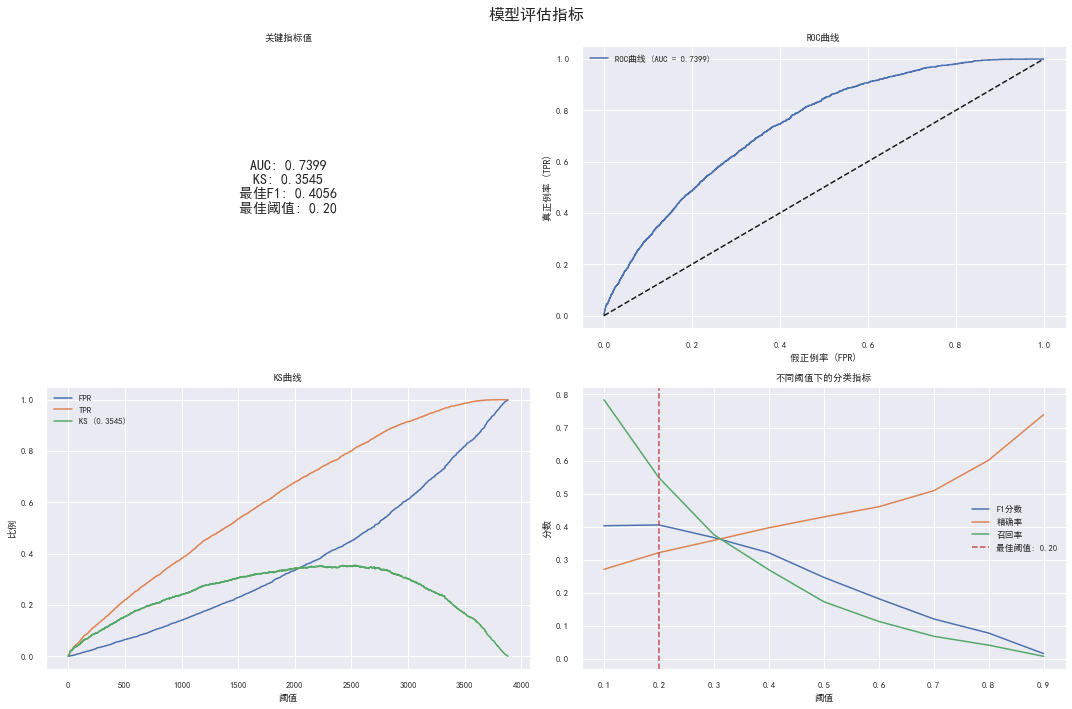

In [9]:
# 定义多指标计算函数
def calculate_metrics(y_true, y_pred_proba):
    """计算多个评估指标"""
    # 计算AUC
    auc = roc_auc_score(y_true, y_pred_proba)
    
    # 计算KS
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    # 计算不同阈值下的F1、精确率、召回率
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    # 找到最佳F1对应的阈值
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc,
        'ks': ks,
        'best_f1': best_f1,
        'best_threshold': best_threshold,
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores
    }

# 定义评估指标可视化函数
def plot_metrics(metrics, figsize=(15, 10)):
    """可视化评估指标"""
    # 创建画布
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 1. AUC和KS值展示
    ax1 = axes[0, 0]
    metrics_text = f"AUC: {metrics['auc']:.4f}\nKS: {metrics['ks']:.4f}\n最佳F1: {metrics['best_f1']:.4f}\n最佳阈值: {metrics['best_threshold']:.2f}"
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # 2. ROC曲线
    ax2 = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基准线
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # 3. KS曲线
    ax3 = axes[1, 0]
    ax3.plot(fpr, label='FPR')
    ax3.plot(tpr, label='TPR')
    ax3.plot(tpr - fpr, label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 4. F1、精确率、召回率随阈值变化
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为suptitle留出空间
    plt.show()


# # 模型评估与可视化


print("\n交叉验证评估结果与可视化...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_auc_scores = []
final_ks_scores = []
final_f1_scores = []

# 保存最后一折的预测结果用于可视化
y_val = None
y_pred_proba = None

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    # 为验证集生成元特征
    val_meta_features = np.zeros((len(val_idx), len(models)))
    
    # 处理DataFrame的索引问题
    if isinstance(train_x, pd.DataFrame):
        X_val = train_x.iloc[val_idx]
    else:
        X_val = train_x[val_idx]
    
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            val_meta_features[:, i] = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            xgb_val = xgb.DMatrix(X_val)
            val_meta_features[:, i] = model.predict(xgb_val, ntree_limit=model.best_iteration)
    
    # 使用元模型预测
    y_pred = meta_model.predict(val_meta_features, num_iteration=meta_model.best_iteration)
    auc = roc_auc_score(train_y[val_idx], y_pred)
    
    # 计算其他指标
    metrics = calculate_metrics(train_y[val_idx], y_pred)
    
    final_auc_scores.append(auc)
    final_ks_scores.append(metrics['ks'])
    final_f1_scores.append(metrics['best_f1'])
    
    # 保存最后一折的结果用于可视化
    if fold == kf.n_splits - 1:
        y_val = train_y[val_idx]
        y_pred_proba = y_pred
        fold_metrics = metrics

print(f"最终Stacking模型的平均AUC: {np.mean(final_auc_scores):.4f} ± {np.std(final_auc_scores):.4f}")
print(f"最终Stacking模型的平均KS: {np.mean(final_ks_scores):.4f} ± {np.std(final_ks_scores):.4f}")
print(f"最终Stacking模型的平均最佳F1: {np.mean(final_f1_scores):.4f} ± {np.std(final_f1_scores):.4f}")

# 绘制最后一折的评估指标可视化
plot_metrics(fold_metrics)

## 5. 保存模型为pkl文件

In [64]:
print("\n保存模型...")
# 将基础模型、元模型和参数配置一起保存
stacking_model = {
    'base_models': models,
    'meta_model': meta_model,
    'model_params': model_params  # 保存参数配置，方便后续查看
}

# 保存到pkl文件
with open('./models/stacking_model_mixed.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("模型已保存为 stacking_model_mixed.pkl")


保存模型...
模型已保存为 stacking_model_mixed.pkl


##  6. 加载模型并进行预测

In [65]:
def predict_with_model(model_path, X):
    """使用保存的stacking模型进行预测"""
    # 加载模型
    with open(model_path, 'rb') as f:
        stacking_model = pickle.load(f)
    
    base_models = stacking_model['base_models']
    meta_model = stacking_model['meta_model']
    
    # 生成元特征
    meta_features = np.zeros((X.shape[0], len(base_models)))
    for i, model_info in enumerate(base_models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            dmatrix = xgb.DMatrix(X)
            meta_features[:, i] = model.predict(dmatrix, ntree_limit=model.best_iteration)
    
    # 元模型预测
    predictions = meta_model.predict(meta_features, num_iteration=meta_model.best_iteration)
    
    return predictions


In [66]:
predictions = predict_with_model('stacking_model_mixed.pkl', test_x)

sub['label'] = predictions
sub.to_csv('./sub/stacking_model_mixed.csv',index = False)
print("预测结果:", predictions)

预测结果: [0.65625253 0.05816585 0.33436996 ... 0.3574981  0.01688246 0.16567397]
